# Problem Set 1, due March 1 by midnight

The goal of this problem set is to replicate and extend the results of  Jean et al.'s 2016 paper, "Combining satellite imagery and machine learning to predict poverty." This problem set will be challenging and time-consuming, so I suggest you start immediately. Your first step should be to carefully read <a href="https://pdfs.semanticscholar.org/1b3a/c4b4187a3dbc9373869e7774b1dc63f748d2.pdf">the original paper</a>  as well as the <a href="http://science.sciencemag.org/content/sci/suppl/2016/08/19/353.6301.790.DC1/Jean.SM.pdf">supplementary materials</a>.

For this assignment, we will focus on the country of Rwanda. You will need to download three distinct datasets, including DHS data, satellite data from the Google Maps API, as well as nighttime luminosity data. The DHS data requires registration (which can take several days to be approved), and the Google Maps API is rate-limited, so it will necessarily take you several days to download the requisite data, so make sure to **get started on those steps asap**. The deep learning section may also take several hours to compute (or days, if you have a slow computer), so don't save it until the last minute.

## Overview of the problem set

These are the key steps in the problem set:

1. Download satellite night lights images from NOAA
2. Download DHS data for Rwanda
3. Test whether night lights data can predict wealth, as observed in DHS
4. Download daytime satellite imagery from Google Maps
5. Test whether basic features of daytime imagery can predict wealth
6. Extract features from daytime imagery using deep learning libraries
7. Replicate final model and results of Jean et al (2016)
8. Construct maps showing the predicted distribution of wealth in Rwanda


# 1. Download nightlights for Rwanda

- **INPUT**:
 - None
- **OUTPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Single image file giving nightlights intensity around the world

Go to the [DMSP-OLS website](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) and download the satellite nighttime luminosity data (roughly 400MB). We will use the one from 2010. The archive they provide constains several files. Feel free to explore these files. We will only be using the file F182010.v4d_web.stable_lights.avg_vis.tif.

A code snippet to get you started is below.

In [ ]:
import wget

night_image_url = 'https://ngdc.noaa.gov/eog/data/web_data/v4composites/F182010.v4.tar'
wget.download(night_image_url)

# 2. Download Rwandan DHS and construct cluster-level aggregates

- **INPUT**: 
  - `rwanda_clusters_location.csv`: Coordinates of the centroid of each cluster
- **OUTPUT**: 
  - `rwanda_cluster_avg_asset_2010.csv`: Comma-delimited file indicated average wealth of each cluster 

[Demographic and Health Surveys (DHS)](http://dhsprogram.com/What-We-Do/Survey-Types/DHS.cfm) are nationally-representative household surveys that provide data for a wide range of monitoring and impact evaluation indicators in the areas of population, health, and nutrition. For this assignment, you will need to download the [2010 Rwandan DHS data](http://dhsprogram.com/what-we-do/survey/survey-display-364.cfm). **This requires registration, so start early!** Do not forget to request for the GPS dataset. Make sure you understand the structure of the data before starting.

Your immediate goal is to take the raw survey data, covering 12,540 households, and compute the average household wealth for each survey cluster (think of a cluster as a village). Refer to the file `Recode6_DHS_22March2013_DHSG4.pdf` for information on these data.

Save your output as `rwanda_cluster_avg_asset_2010.csv` and check that it matches the file that we have provided. You will use this file as input to the next step in the assignment.

Hints:
- `Household Recode` contains all the attributes of each household. It provides datasets with different formats. Feel free to explore the data. You can use `RWHR61FL.DAT` file in Flat ASCII data (.dat) format.
- `RWHR61FL.DCF` describes the attributes and the location of each attribute.
- Geographic Datasets: `rwge61fl.zip` contains the location of each cluster in Rwanda. It is in the format of shapefile, which needs QGIS or other GIS softwares to open. For those who are not familiar with GIS tools or who want a shortcut, you can also sue the file `rwanda_clusters_location.csv` provided with the problem set.

For reference, the cluster locations, overlaid on the nightlights data, are shown in the figure below.
<img src="figure/map1.png" alt="Map" style="width: 600px;"/>

In [1]:
# Your code here


### BEGIN SOLUTION ####

import pandas as pd
import numpy as np

file_name = 'RWHR61FL.DAT'
cluster_file = 'rwanda_clusters_location.csv'
cluster_all = []
wealth_all = []
with open(file_name) as f:
    for line in f:
        cluster = int(line[15:23])
        wealth = int(line[230:238]) / 100000.0
        cluster_all.append(cluster)
        wealth_all.append(wealth)

df = pd.DataFrame({'cluster': cluster_all, 'wlthindf': wealth_all})
cluster_avg_asset = df.groupby('cluster')['wlthindf'].median().reset_index()

df_location = pd.read_csv(cluster_file)[['DHSCLUST', 'LATNUM', 'LONGNUM']]
result = cluster_avg_asset.merge(df_location, how='inner', left_on='cluster', right_on='DHSCLUST')[['cluster', 'wlthindf', 'LATNUM', 'LONGNUM']]
result.rename(columns={'LATNUM': 'latitude', 'LONGNUM':'longitude'}, inplace=True)
result.to_csv('rwanda_cluster_avg_asset_2010.csv', index=False)

# 3. Test whether night lights data can predict wealth, as observed in DHS

Now that you have "ground truth" measures of average cluster wealth, your goal is to understand whether the nightlights data can be used to predict wealth. First, merge the DHS and nightlights data, and then fit a model of wealth on nightlights.

## 3.1 Merge nightlights and DHS data at cluster level
- **INPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Nightlights data, from Step 1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `DHS_nightlights.csv`: Merged dataset with 492 rows, and 6 columns (one indicates average cluster wealth, 5 nightlights features)
 - Scatterplot of nightlights vs. DHS wealth

Perform a "spatial join" to compute the average nighttime luminosity for each of the DHS clusters. To do this, you should take the average of the luminosity values for the nightlights locations surrounding the cluster centroid.

Save your output as `DHS_nightlights.csv` and check that it is the same as the file we have provided.

Create a scatterplot showing the relationship between average cluster wealth (y-axis) and average nighttime luminosity (x-axis). Your scatterplot should have one dot for each of the 492 DHS clusters. Report the R^2 of the regression line.

Hints:
 - The resolution of each pixel in the nightlight image is about 1km. Use 10 pixels X 10 pixels to average the luminosity of each cluster.
 - Start by just taking the **Mean** of the luminosity in the 100 pixels and comparing this to cluster average wealth. If you like, you could also compute other luminosity characteristics of each cluster, such as the **Max**, **Min**, **Standard Deviation** of the 100 pixel values, but this step is not required. Note that the file we provide (`DHS_nightlights.csv`) has these added features.
 - To read the raw raster (nightlights) files, we recommend using the GDAL library. Use `conda install gdal` to install the GDAL library. We have provided some helper code for this below.

In [ ]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
import cStringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib

# Helper function to read a raster file
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)


# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [9]:
# read the nightlight image
raster_file = 'data/nighttime_image/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = \
read_raster(raster_file)

np.savez('nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [4]:
# Your code here


### BEGIN SOLUTION ####

# get nightlight features for each cluster
def get_nightlight_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in xrange(left_idx, right_idx + 1):
        for j in xrange(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'id': idx, 'max_': max_, 'min_': min_, 'mean_': mean_, 'median_': median_, 'std_': std_, 'wealth': wealth})

In [7]:
clusters = pd.read_csv('rwanda_cluster_avg_asset_2010.csv')
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv('DHS_nightlights.csv', index=None)

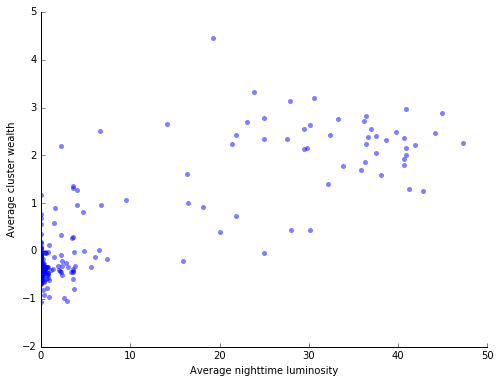

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data_all['mean_'], data_all['wealth'], 'o', c='b', markersize=5, markeredgecolor='none', alpha=0.5)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## 3.2. Fit a model of wealth as a function of nightlights
- **INPUT**: 
 - `DHS_nightlights.csv`, from Step 3.1
- **OUTPUT**: 
 - R^2 of model
 
Above, you fit a regression line to illustrate the relationship between cluster average wealth and corresponding cluster nightlights. Now, use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) to get a better sense of out of sample accuracy.

There are two options for this. The basic way, for those new to machine learning, is to randomly divide your dataset into a training and a test dataset. Randomly select 80% of your clusters and fit a model of cluster-average DHS wealth (your response/dependent variable) on nightlights (your predictor/independent variables). You can use a regression or any other model you prefer. Then, use that model to predict the wealth of the remaining 20% of your data, and compare the predicted values to the actual values, and report the R^2 on these 20%.

The preferred way is to use 10-fold cross-validation, where you repeat the above procedure 10 times, so that you have 10 different and non-overlapping test sets. Then, you report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

Hints:
 - The scikit learn library has built-in functions for [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) that make this quite easy.
 


In [15]:
# Your code here
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


### BEGIN SOLUTION ####
data_all = pd.read_csv('DHS_nightlights.csv')
data_array = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].as_matrix()
np.random.seed(123)
# np.random.shuffle(data_array)
kf = KFold(n_splits=10)

scores = []
index_all = []
for train_index, test_index in kf.split(data_array):
    clf = Ridge(alpha=1.0)
    train = data_array[train_index]
    test = data_array[test_index]
    clf.fit(train[:, :-1], train[:, -1])
    s = clf.score(test[:, :-1], test[:, -1])
    scores.append(s)
    index_all.append([train_index, test_index])

print np.mean(scores)

0.723991901268


In [29]:
scores = np.asarray(scores)
min_idx = np.where(scores == max(scores))

train_index, test_index = index_all[min_idx[0][0]]
clf = Ridge(alpha=1.0)
train = data_array[train_index]
test = data_array[test_index]
clf.fit(train[:, :-1], train[:, -1])
print clf.score(test[:, :-1], test[:, -1])

0.908133127504


In [25]:
# save the model
import cPickle
with open('model_nightlight.pkl', 'wb') as fid:
    cPickle.dump(clf, fid)    

# load it again
# with open('model_nightlight.pkl', 'rb') as fid:
#      clf = cPickle.load(fid)
# 
# clf.score(test[:, :-1], test[:, -1])

# 4. Download daytime satellite imagery 
- **INPUT**: 
 - Google Maps API key
 - `Sector_Boundary_2012.shp`: Rwandan shapefile
- **OUTPUT**: 
 - Thousands of satellite images (store in directory `google_image/`)

We will use the Google Static Maps API to download satellite images. Refer [Google Static Maps introduction](https://developers.google.com/maps/documentation/static-maps/intro) and [Google Static Maps API Usage Limits](https://developers.google.com/maps/documentation/static-maps/usage-limits). You must apply for an API key before downloading. ** Note that it will take you several days to download the required images, so start early!**

Download the images from Google at zoom level 16 (pixel resolution is about 2.5m). Set the image size to be 400 pixels X 400 pixels, so that each image you download will cover 1 square kilometer. In this way, each daytime image you download will correspond to a single pixel from the nighttime imagery from Step 1 above.

Hints:
 - You will need to tell Google the locations for which you wish to download images. One way to do this is to use a [shapefiles](https://en.wikipedia.org/wiki/Shapefile) that specifies the borders of Rwanda. We have provided this shapefile (`Sector_Boundary_2012.shp`) as well as a helper function to read in the shapefile.
 - You can organize the files however you like. However, for later analysis (Steps 6 and beyond), it may help if you organize these daytime images into 64 folders, with one folder indicating the nightlight intensity of the pixel corresponding to the daytime image. In other words, if you download a daytime image for which the corresponding nighttime pixel has value 32, store that daytime image in a folder labeled '32'. This way, all the satellite images within each folder will have the same nightlight intensity. The file name is columnIndex_rowIndex.jpg, in which row index and column index are the index in the nightlight image (See the diagram below).

![title](figure/data_description.png)

In [ ]:
# Helper function to read a shapefile
def get_shp_extent(shp_file):
    """
    Function
    --------
    get_shp_extent

    Given a shapefile, get the extent

    Parameters
    ----------
    shp_file : string
        Path to the shapefile
    
    Returns
    -------
    extent : tuple
        Boundary location of the shapefile (x_min, x_max, y_min, y_max)
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(inShapefile, 0)
    inLayer = inDataSource.GetLayer()
    extent = inLayer.GetExtent()
    # x_min_shp, x_max_shp, y_min_shp, y_max_shp = extent
    return extent

In [ ]:
# Your code here

### BEGIN SOLUTION ####
from retrying import retry


@retry(wait_exponential_multiplier=1000, wait_exponential_max=3600000)
def save_img(url, file_path, file_name):
    """
    Function
    --------
    save_img

    Given a url of the map, save the image

    Parameters
    ----------
    url : string
        URL of the map from Google Map Static API
    file_path : string
        Folder name of the map
    file_name : string
        File name
    
    Returns
    -------
    None
    """
    a = urllib.urlopen(url).read()
    b = cStringIO.StringIO(a)
    image = ndimage.imread(b, mode='RGB')
    # when no image exists, api will return an image with the same color. 
    # and in the center of the image, it said'Sorry. We have no imagery here'.
    # we should drop these images if large area of the image has the same color.
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        misc.imsave(file_path + file_name, image[50:450, :, :])

# Now read in the shapefile for Rwanda and extract the edges of the country
inShapefile = "data/shp/Sector_Boundary_2012/Sector_Boundary_2012.shp"
x_min_shp, x_max_shp, y_min_shp, y_max_shp = a

left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)


key = 'YOUR_GOOGLE_MAP_API_KEY'
m = 1
for i in xrange(left_idx, right_idx + 1):
    for j in xrange(top_idx, bottom_idx + 1):
        lon = centroid_x_coords[i]
        lat = centroid_y_coords[j]
        url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
               str(lon) + '&zoom=16&size=400x500&maptype=satellite&key=' + key
        lightness = bands_data[j, i, 0]
        file_path = 'google_image/' + str(lightness) + '/'
        if not os.path.isdir(file_path):
            os.makedirs(file_path)
        file_name = str(i) + '_' + str(j) +'.jpg'
        save_img(url, file_path, file_name)
        if m % 100 == 0:
            print m
        m += 1

shapefile read
100
200
300


# 5. Test whether basic features of daytime imagery can predict wealth
In step 3, you tested whether nightlight imagery could predict the wealth of Rwandan villages. You will now test whether daytime imagery can predict village wealth. Start by extracting simple metrics from the daytime imagery; in step 6 you will use more sophsticated methods to engineer these features from the images. **You don't need to do this step if you are able to do step 6.**

## 5.1. Extract "basic" features from daytime imagery
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_basic.csv`: Image features 

Convert the raw data from the satellite imagery into a set of features that can be used in a machine learning algorithm. A simple way to do this is to take the raw R/G/B values for each pixel and average them for the image. Thus, if an image has 100 pixels, you will have an average R value, an average G value, and an average B value. Create more features by also computing the min, max, median, and standard deviation of R, G, and B for each image. This process will convert each image into a vector of 15 features.

Feel free to be creative if you wish to generate additional features from the imagery -- this is similar to the process described in section 2.3 of the paper's supplementary materials. But don't waste too much time, and don't expect these features to be terribly useful.

In [ ]:
# Your code here


### BEGIN SOLUTION ####

images_name = []
for i in range(64):
    dir_ = 'google_image/' + str(i) + '/'
    image_files = os.listdir(dir_)
    images_name.append(image_files)

In [ ]:
def get_image_basic_feature(image_file):
    image = ndimage.imread(image_file, mode='RGB')
    features = []
    for i in range(3):
        image_one_band = image[:, :, i].flatten()
        features.append(image_one_band)
    return np.asarray(features)

In [42]:
def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in xrange(left_idx, right_idx + 1):
        for j in xrange(up_idx, low_idx + 1):
            luminosity = bands_data[j, i, 0]
            file_name = str(i) + '_' + str(j) +'.jpg'
            if file_name in images_name[luminosity]:
                feature = get_image_basic_feature('google_image/' + str(luminosity) + '/' + file_name)
                features_100.append(feature)
    if len(features_100) == 0:
        return np.asarray([np.nan] * 15 + [wealth]).tolist()
    else:
        features_all = np.concatenate(features_100, axis=1)
        max_ = np.max(features_all, axis=1)
        min_ = np.min(features_all, axis=1)
        mean_ = np.mean(features_all, axis=1)
        median_ = np.median(features_all, axis=1)
        std_ = np.std(features_all, axis=1)
        return np.concatenate([max_, min_, mean_, median_, std_, [wealth]]).tolist()

## 5.2. Merge daytime images with DHS data

- **INPUT**: 
 - `google_image_features_basic.csv`: Satellite imagery features, from Step 5.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 16 columns (one indicates average cluster wealth, 15 daytime image features)

Now that you have feature vectors for each image, you should merge these with the DHS data indicated average cluster wealth. Follow a similar procedure as you did with 3.1, i.e., determine which image feature vectors are associated with each cluster, and then calculate, for each cluster, the average value of each feature.

Save your output as `DHS_daytime.csv` and check that it is roughly the same as the file we have provided. There may be slight differences if you chose to calculate a different set of features than those described in 5.1.

In [ ]:
# Your code here


### BEGIN SOLUTION ####

clusters = pd.read_csv('rwanda_cluster_avg_asset_2010.csv')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt('google_image_features_basic.csv', data_all)

## 5.3. Fit a model of wealth as a function of basic daytime features
- **INPUT**: 
 - `data/model/DHS_daytime.csv`, from Step 5.2
- **OUTPUT**: 
 - R^2 of model
 
As in 3.2, use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the nightlights data (your predictor/independent variables). Since you have a reasonably large number of predictor variables, you should use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).


In [ ]:
# Your code here


### BEGIN SOLUTION ####

data_all = np.loadtxt('google_image_features_basic.csv')

kf = KFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(data_all):
    clf = Ridge(alpha=1.0)
    train = data_all[train_index]
    test = data_all[test_index]
    clf.fit(train[:, :-1], train[:, -1])
    s = clf.score(test[:, :-1], test[:, -1])
    scores.append(s)

print np.mean(scores) # 0.166

In [ ]:
rows_train = np.random.choice(range(len(data_all)), int(round(len(data_all) * 0.66)), replace=False)
rows_test = list(set(range(len(data_all))) - set(rows_train))

x_train = data_all[rows_train, :-1]
x_test = data_all[rows_test, :-1]

y_train = data_all[rows_train, -1]
y_test = data_all[rows_test, -1]


reg = RidgeCV(alphas=(0.1, 1.0, 10.0, 50.0, 100.0, 1000.0, 100000.0), cv=10)
reg.fit(x_train, y_train)
print reg.alpha_
print reg.coef_
r_square = reg.score(x_test, y_test)
print r_square  # 0.16

# 6. Extract features from daytime imagery using deep learning libraries

This is where things get interesting. Above, you have seen that the RGB features of the daytime images are not great at predicting cluster average wealth (why not?). Now, you will use existing libraries to extract more meaningful features from the daytime imagery, similar to what is shown in Fig. 2 of the paper.

## 6.1. Use the keras library to use a basic CNN to extract features of the daytime images 
 
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn.csv`: Image features 

Begin by using a Convolutional Neural Network that has been pre-trained on ImageNet to extract features from the images. We recommend using the [`Keras` library](https://keras.io/), which provides a very straightforward interface to [TensorFlow](https://www.tensorflow.org/).

Hints:
 - This [short intro](https://github.com/fchollet/deep-learning-models/blob/master/README.md) will help you get started with extracting features from the CNN.

In [ ]:
# Your code here

### BEGIN SOLUTION ####

from vgg16 import VGG16
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from imagenet_utils import preprocess_input, decode_predictions
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.optimizers import SGD
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from multiprocessing import Pool
import os
import time
import pandas as pd
import numpy as np
from keras.models import Model


# load nightlight data
npzfile = np.load('nightlight.npz')
print npzfile.files
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']


def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

# get image featuers
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output)

images_name = []
for i in range(64):
    dir_ = 'google_image/' + str(i) + '/'
    image_files = os.listdir(dir_)
    images_name.append(image_files)


def get_input_feature(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features[0]


def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    print idx
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in xrange(left_idx, right_idx + 1):
        for j in xrange(up_idx, low_idx + 1):
            luminosity = bands_data[j, i, 0]
            file_name = str(i) + '_' + str(j) + '.jpg'
            if file_name in images_name[luminosity]:
                feature = get_input_feature('google_image/' + str(luminosity) + '/' + file_name)
                features_100.append(feature)
    if len(features_100) == 0:
        return np.asarray([np.nan] * 4096 + [wealth]).tolist()
    else:
        features_100 = np.asarray(features_100)
        return np.append(np.mean(features_100, axis=0), wealth).tolist()


clusters = pd.read_csv('rwanda_cluster_avg_asset_2010.csv')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt('google_image_features_cnn.csv', data_all)

# 6.2. Test whether these new features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_features_cnn.csv`: Satellite imagery features, from Step 6.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 nightlights features)
 - R^2 of model
 
Calculate the average value of each feature for each of the DHS clusters. As in Step 3.1 and 5.2, you will want to aggregate over images near the cluster centroid by taking the average value for each feature. Create a scatterplot showing the relationship between average cluster wealth (y-axis) and the first principal component of all of your image features (x-axis) - in other words, run PCA on your 4096 image features and plot the first PC on the x-axis. Your scatterplot should have one dot for each of the 492 DHS clusters.

Use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the "deep" features (your predictor/independent variables). Use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

['data_all']


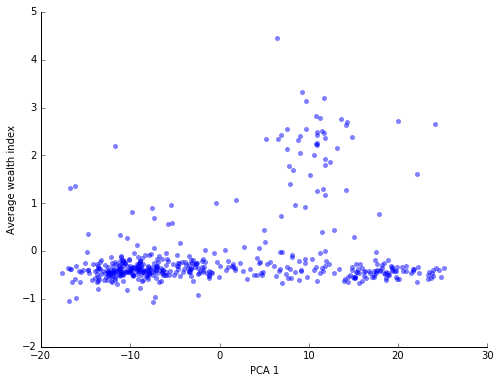

In [33]:
from sklearn.decomposition import PCA

# Your code here

### BEGIN SOLUTION ####

data_all = np.loadtxt('google_image_features_cnn.csv')
x = data_all[:, :-1]
y = data_all[:, -1]
pca = PCA(n_components=1)
pca.fit(x)
proj = pca.fit_transform(x)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(proj[:,0], y, 'o', c='blue', markersize=5, markeredgecolor='none', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('Average wealth index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [39]:
kf = KFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(data_all):
    clf = Ridge(alpha=100.0)
    train = data_all[train_index]
    test = data_all[test_index]
    clf.fit(train[:, :-1], train[:, -1])
    s = clf.score(test[:, :-1], test[:, -1])
    scores.append(s)

print np.mean(scores)

0.632258913315


In [38]:
from sklearn.linear_model import RidgeCV

rows_train = np.random.choice(range(len(data_all)), int(round(len(data_all) * 0.66)), replace=False)
rows_test = list(set(range(len(data_all))) - set(rows_train))

x_train = data_all[rows_train, :-1]
x_test = data_all[rows_test, :-1]

y_train = data_all[rows_train, -1]
y_test = data_all[rows_test, -1]


# ridge
reg = RidgeCV(alphas=(0.1, 1.0, 10.0, 50.0, 100.0, 1000.0, 100000.0), cv=10)
reg.fit(x_train, y_train)
print reg.alpha_
print reg.coef_
r_square = reg.score(x_test, y_test)
print r_square

100.0
[-0.00136089  0.00933641 -0.00490216 ..., -0.00042343 -0.00541549
 -0.00153458]
0.602143580254


# 7. Replicate final model and results of Jean et al (2016)

The only thing missing at this point is the "transfer learning" step. In other words, instead of using the image features extracted by the CNN directly, we want to retrain the CNN to predict nightlights from daytime imagery, and use those features, which presumably are more appropriate to our final prediction task.

## 7.1. Use the nightlights to retrain the CNN and extract features

Following the approach used in the paper, first divide your daytime images into three groups, corresponding to images where the corresponding night-lights pixel is dim, medium, or bright. Use these values to define your groups: [0, 3), [3, 35), [35, 64). We have given you the code to do this below.

In [ ]:
def move_to_group(lightness_small, lightness_big, class_id):
    new_directory = 'google_image_cnn/class_' + str(class_id) + '/'
    if not os.path.isdir(new_directory):
        os.makedirs(new_directory)
    for i in range(lightness_small, lightness_big):
        path = 'google_image/' + str(i) + '/'
        for f in os.listdir(path):
            copyfile(path + f, new_directory + f)

move_to_group(0, 3, 1)
move_to_group(3, 35, 2)
move_to_group(35, 64, 3)

## 7.2. Test whether "deep" features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_cnn/...`: Satellite images from 7.1
- **OUTPUT**: 
 - `Model`: store as object xxx
 
**TODO: add description of what needs to be done**

Hints:
 - X 


In [ ]:
# Your code here
model_old = VGG16(weights='imagenet', include_top=False)


def get_input_feature(img_path):
    # img = image.load_img(img_path, target_size=(400, 400))
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_old.predict(x)
    return features[0]


all_figures = []
trainLabels = []

path_1 = 'google_image_cnn_upsampling/class_1/'
class_1_files = os.listdir(path_1)
trainLabels += [[1, 0, 0]] * len(class_1_files)
all_figures += [path_1 + i for i in class_1_files]

path_2 = 'google_image_cnn_upsampling/class_2/'
class_2_files = os.listdir(path_2)
trainLabels += [[0, 1, 0]] * len(class_2_files)
all_figures += [path_2 + i for i in class_2_files]

path_3 = 'google_image_cnn_upsampling/class_3/'
class_3_files = os.listdir(path_3)
trainLabels += [[0, 0, 1]] * len(class_3_files)
all_figures += [path_3 + i for i in class_3_files]


# a = get_input_feature(all_figures[0])
# pool = Pool(10)
# trainData = pool.map(get_input_feature, all_figures)

trainData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    trainData.append(a)
    if idx % 1000 == 0:
        t2 = time.time()
        print idx
        print t2 - t1
        t1 = time.time()


x_all = np.asarray(trainData)
y_all = np.asarray(trainLabels)

# np.savez('google_image_feature.npz', x_all=x_all, y_all=y_all)
np.savez('google_image_feature_not_upsampling.npz', x_all=x_all, y_all=y_all)

npzfile = np.load('google_image_feature.npz')
print npzfile.files
x_all = npzfile['x_all']
y_all = npzfile['y_all']


np.random.seed(seed=123)

class_1_num = y_all[:,0].sum()
class_2_num = y_all[:,1].sum()
class_3_num = y_all[:,2].sum()

x_all_1 = x_all[:class_1_num, ]
x_all_2 = x_all[class_1_num:(class_1_num + class_2_num), ]
x_all_3 = x_all[(class_1_num + class_2_num):, ]

y_all_1 = y_all[:class_1_num, ]
y_all_2 = y_all[class_1_num:(class_1_num + class_2_num), ]
y_all_3 = y_all[(class_1_num + class_2_num):, ]


# for each class, select 33% as the test set
rows_train = np.random.choice(range(len(x_all)), int(round(len(x_all) * 0.66)), replace=False)
rows_test = list(set(range(len(x_all))) - set(rows_train))

x_train = x_all[rows_train]
x_test = x_all[rows_test]
y_train = y_all[rows_train]
y_test = y_all[rows_test]


# the model configuration: https://github.com/nealjean/predicting-poverty/blob/master/model/predicting_poverty_deploy.prototxt
model = Sequential()
model.add(Convolution2D(4096, 6, 6, activation='relu', input_shape=(12, 12, 512), subsample=(6, 6), name='input'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, 1, 1, activation='relu', subsample=(1, 1), name='conv_7'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, 1, 1, subsample=(1, 1), name='conv_8'))
model.add(AveragePooling2D((2, 2), strides=(1, 1), name='add_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(3))
model.add(Activation("softmax"))

opt = SGD(lr=1e-2)
# model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=100, nb_epoch=2000, verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print score

To have an understanding how convolution layers work, can you visulize the weights in one convolution layer?

# 8. Construct map

**INPUT**: Model, image features (data/model/features_all_predictimage_location.csv)

**OUTPUT**: Map ('poverty_mapping.tiff')

In [ ]:
def array_to_raster(x_size, y_size, left, top, bands_data, no_data_value, filename):
    driver = gdal.GetDriverByName('GTiff')

    dataset = driver.Create(
        filename,
        bands_data.shape[1],
        bands_data.shape[0],
        1,
        gdal.GDT_Float32, )

    dataset.SetGeoTransform((
        left,
        x_size,
        0,
        top,
        0,
        y_size))

    # dataset.SetProjection(wgs84)
    outband = dataset.GetRasterBand(1)
    outband.WriteArray(bands_data[:, :, 0])
    outband.FlushCache()  # Write to disk.
    outband.SetNoDataValue(no_data_value)


features_all_predict = np.genfromtxt('data/model/features_all_predict.csv', delimiter=',')
image_loc = np.genfromtxt('data/model/image_loc.csv', delimiter=',')

x_image_num = right_idx + 1 - left_idx
y_image_num = bottom_idx + 1 - top_idx

output_array = np.ndarray(shape=(y_image_num, x_image_num, 1))
no_data_value = 100
output_array.fill(no_data_value)

for idx, v in enumerate(image_loc):
    x, y = v
    x_id = x - left_idx
    y_id = y - top_idx
    output_array[y_id, x_id, 0] = features_all_predict[idx]

array_to_raster(x_size, - x_size, top_left_x_coords[left_idx], top_left_y_coords[top_idx], output_array, no_data_value, 'poverty_mapping.tiff')